### Loading the environment

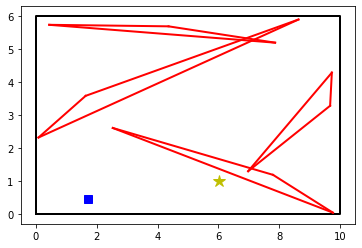

In [258]:
import numpy as np
import pylab as pl
import sys
sys.path.append('osr_examples/scripts/')
import environment_2d
pl.ion()
np.random.seed(4)
env = environment_2d.Environment(10, 6, 4)
pl.clf()
env.plot()
q = env.random_query()
if q is not None:
  x_start, y_start, x_goal, y_goal = q
  env.plot_query(x_start, y_start, x_goal, y_goal)
    


### Generating the Graph class

In [322]:
class Graph:
    def __init__(self):
        self.nodes = set()
        self.edges = list()

    def add_node(self, node):
        self.nodes.add(node)

    def add_edge(self, from_node, to_node, length):
        self.edges.append((from_node, to_node, length))
        
    def checkPath(self, s, e):
        generatePaths = {}
        visited = {}
        for xy1, xy2, d in self.edges:
            if xy1 not in generatePaths:
                generatePaths[xy1] = [xy2]
                visited[xy1] = False
            else:
                generatePaths[xy1].append(xy2)
                
        if -1 not in generatePaths or -2 not in generatePaths:
            return False
        
        queue = []
        queue.append(s)
        while queue:
            n = queue.pop(0)
            if n == e:
                return True
            
            for i in generatePaths[n]:
                if visited[i] == False:
                    queue.append(i)
                    visited[i] = True
        return False
    
    def printPath(self, s, e, visited=None, generatePaths=None, path=[]):
        if visited == None and generatePaths == None:
            path = []
            generatePaths = {}
            visited = {}
            for xy1, xy2, d in self.edges:
                if xy1 not in generatePaths:
                    generatePaths[xy1] = [xy2]
                    visited[xy1] = False
                else:
                    generatePaths[xy1].append(xy2)
    
        visited[s] = True
        path.append(s)
        if s == e:
            return
        
        for i in generatePaths[s]:
            if visited[i] == False:
                self.printPath(i, e, visited, generatePaths, path)
                
        return path

### PRM Algorithm

In [320]:
from sklearn.neighbors import NearestNeighbors

class PRM:
    def __init__(self, x, y, start, end):
        self.x = x
        self.y = y
        self.start = start
        self.end = end
        self.sample_points = None
        self.c_free = None
        self.graph = Graph()
        
        
    def genSamples(self, n):
        self.sample_points = np.random.randint((self.x, self.y), size=(n, 2))
    
    def checkForCollision(self):
        self.c_free = np.array([])
        for x, y in self.sample_points:
            if not env.check_collision(x,y):
                if self.c_free.size == 0:
                    self.c_free = np.array((x, y))
                else:
                    self.c_free = np.vstack([self.c_free, (x, y)])
    
    def checkLineCollision(self, start_line, end_line):
        x1, y1, x2, y2 = start_line[0], start_line[1], end_line[0], end_line[1]
        if x2 - x1 == 0:
            gradient = 0
        else:
            gradient = (y2-y1)/(x2-x1)
        constant = y1 - gradient * x1
        x_path = np.linspace(min(x1, x2), max(x1, x2), 100)
        y_path = np.linspace(min(y1, y2), max(y1, y2), 100)
        #y_path = x_path * gradient + constant
        for x, y in zip(x_path, y_path):
            if env.check_collision(x, y):
                return True
            
        return False
    
    def determinePath(self, radius):
        X = self.c_free
        knn = NearestNeighbors(n_neighbors=len(X))
        knn.fit(X)
        distances, indices = knn.kneighbors(X)
        for idx, point in enumerate(self.c_free):
            neighbour_index = indices[idx][1:]
            for neighbour, distance in zip(neighbour_index, distances[idx][1:]):
                if 0 < distance <= radius:
                    start_line = point
                    end_line = X[neighbour]
                    if not self.checkLineCollision(start_line, end_line):
                        self.graph.add_node(idx)
                        self.graph.add_node(neighbour)
                        self.graph.add_edge(idx, neighbour, distance)
        
    def checkStartEnd(self):
        x_start, y_start = self.start
        x_end, y_end = self.end
        cpy = self.graph.nodes.copy()
        for idx in cpy:
            coordinate = self.c_free[idx]
            # -1 for start 
            if not self.checkLineCollision(self.start, coordinate):
                self.graph.add_node(-1)
                self.graph.add_edge(-1, idx, self.distanceOfTwoPoints(self.start, coordinate))
            # -2 for end
            if not self.checkLineCollision(self.end, coordinate):
                self.graph.add_node(-2)
                self.graph.add_edge(-2, idx, self.distanceOfTwoPoints(self.end, coordinate))
                
        # Check if start to end works
        if not self.checkLineCollision(self.start, self.end):
            self.graph.add_node(-1)
            self.graph.add_node(-2)
            self.graph.add_edge(-1, -2, self.distanceOfTwoPoints(self.start, self.end))
        
        return
        
    def distanceOfTwoPoints(self, first, end):
        x, y = first
        x2, y2 = end
        return ((x-x2)**2 + (y-y2)**2)**0.5
    
    def runPRM(self, radius=2):
        # Generate the sample points
        self.genSamples(10)
        
        # Remove any points that are colliding with the Environment
        self.checkForCollision()
        
        # Determine the straight path between sample points that work
        self.determinePath(radius)
        
        # Check if start and end points can join this connected component
        self.checkStartEnd()
        
        
        if self.graph.checkPath(-1, -2):
            return self.graph.printPath(-1, -2)
        
        return False

<b> Testing the code </b>

The dependency of this algorithm is on the random sample points generated initially. In some cases, the random points generated do not have a path actually

In [332]:
x_start, y_start, x_goal, y_goal = q
prm_model = PRM(10, 6, (x_start, y_start), (x_goal, y_goal))
path = prm_model.runPRM(2)
if path != False:
    print("The coordinates to take:")
    for i in path:
        print(prm_model.c_free[i])
        
else:
    print("This iteration does not generate a sample path, re-run the code which will generate a new set of sample points that might contain a path")

The coordinates to take:
[8 0]
[1 1]
[1 0]
[2 0]
[2 0]


<b> Visualizing the multiple connected components from our sample points </b>

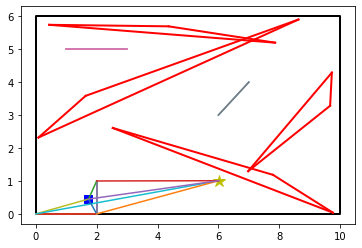

In [325]:
env.plot_query(x_start, y_start, x_goal, y_goal)
env.plot()
for x, y, z in prm_model.graph.edges:
    if x >= 0:
        a = prm_model.c_free[x]
    elif x == -1:
        a = prm_model.start
    else:
        a = prm_model.end
        
    if y >= 0:
        b = prm_model.c_free[y]
    elif y == -1:
        b = prm_model.start
    else:
        b = prm_model.end

    pl.plot([a[0], b[0]], [a[1], b[1]])
    

<b>Note: </b> A further step forward would be to optimise the distance using Dijkstra's or A* algorithm. However, as I had only started the project 2 days before the deadline due to my ongoing exams, this is an approach that I will look into during my free time. Nonetheless, I thank the readers for taking time off to view my work. Have a nice day!